## Making a bathymetry mesh and export a GeoTIFF from point clouds and bathymetric surveys
In this notebook we demonstrate the full process to go from a sparse set of points in a stream to a bathymetric model of the stream using geomorphological principles. In order we do the following:
- [x] prepare a "mesh" object from a set of splines
- [x] provide points from a fishfinder survey to the mesh
- [x] optimize bathymetric parameters of the mesh
- [x] refine the more specific small-scale parameters
- [x] export the mesh to a NetCDF file and a GeoTIFF

### Make a mesh object from splines
In our examples data folder, we have a set of splines prepared. Let's first have a look at these by loading them into geopandas and make a very very simple plot. Geopandas is a library that can be used to load, save and manipulate geospatial vector data such as points, lines and polygons.

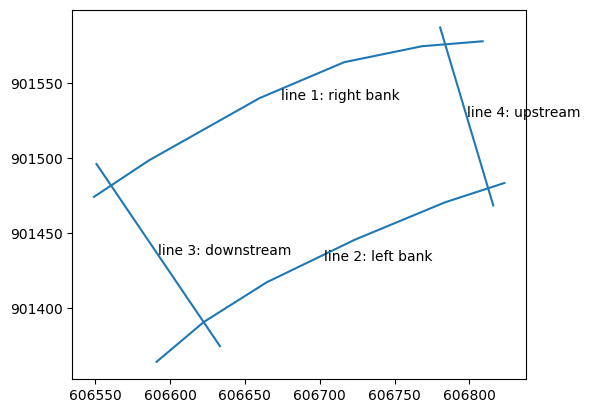

In [18]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
splines = gpd.read_file("../examples/data/splines.geojson")
splines.plot()

# we'll annotate so that things are clear. We plot annotations at the centroid of each line

annot = ["right bank", "left bank",  "downstream", "upstream"]
for n, (geom, text) in enumerate(zip(splines.geometry, annot)):
    plt.text(
        *np.array(geom.centroid.xy).flatten(),
        f"line {n + 1}: {text}"
    )


These lines can be drawn in a GIS such as QGIS. It is important to note a few things:
- the order is important. The first two splines should contain the left and right bank (top and bottom slightly curved lines in figure), the third and fourth the lines perpendicular to the stream (two straight lines on left and right side).
- The lines along the banks should be following the shoreline as much as possible during the measurement campaign and should be as straight as possible. The lines may contain multiple vertices as you can see.
- The perpendicular lines *MUST* be only one vertex (click only two points to create them).

Now we can use these to generate a mesh as follows.

<GeoAxes: >

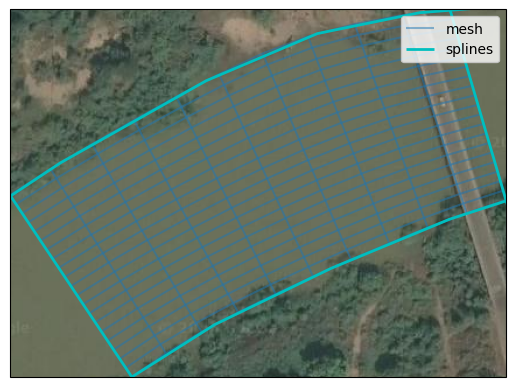

In [22]:
from orprofile import api

mesh = api.mesh.Mesh(splines, n=20, m=10)
mesh.plot()
# fn_points = "../examples/data/bamboi_survey.geojson"
# mesh = api.mesh.Mesh(splines, n=50, m=100, points=fn_points)

# mesh.plot()

Let's explain this further. ORPRofile has a so-called `Mesh` class, which generates a mesh (or grid) with some intelligence. A mesh is essentially a grid, in our case a so-called curvilinear grid. It looks almost like a regular grid but can be shaped in certain directions. A `Mesh` object can consequently read in your data, analyze the likely geomorphological regime belonging to it by fitting a model based on Lacey's equation, and then estimate depths using the fit within the mesh grid cells. This can then provide insights on the bathymetry, and also where the Lacey assumptions do not seem to apply very well. This is where residuals between observations and fitted depths are poor. These are likely locations where there is some non-natural influence on the sedimentation process. Naturally this only applies in alluvial depositing stream sections.

In detail, in the code we simply say that we want a mesh initiated within the area defined by the 4 splines, and that this mesh should contain 20 rows and 10 columns. The mesh will then be made in between the 4 splines. The plot also shows a nice satellite view. There are some further options for the plot, which are documented in our API documentation. Please have a look at that for further options.

## Make a random bathymetry using the Lacey model.
The cool thing is that the the mesh object understand some regime theory. We have made a 2-dimensional model that estimates bathymetry using 5 different parameters. We assume that there is always a "deepest point" $h_m$ over perpendicular sections and that this deepest point meanders in between the left and right natural levee following a 3-parameter sinus function. The natural levees can be further away from the two left and right splines that we have drawn. These splines merely denote the left and right wetted banks during the survey. The parameters of the model are:

* $A$ [m$^2$]: the wetted surface (assumed constant over the entire longitudinal reach).
* $c$ [-]: dimensionless constant defining how $h_m$ relates to the grid width at a given location. This is the typical Lacey law, i.e. that there is a depth / width ratio, dependent on the sediment types (fine sediments: depth/width is small, coarse sediments: depth/width is large)
* $\alpha$ [m]: the amplitude of the offset from the center of the deepest point. Measures the scale of the meanders.
* $L$ [m]: the length scale (wave length) of the offset of deepest point sinus.
* $\kappa$ [rad]: the phase of the deepest point sinus.



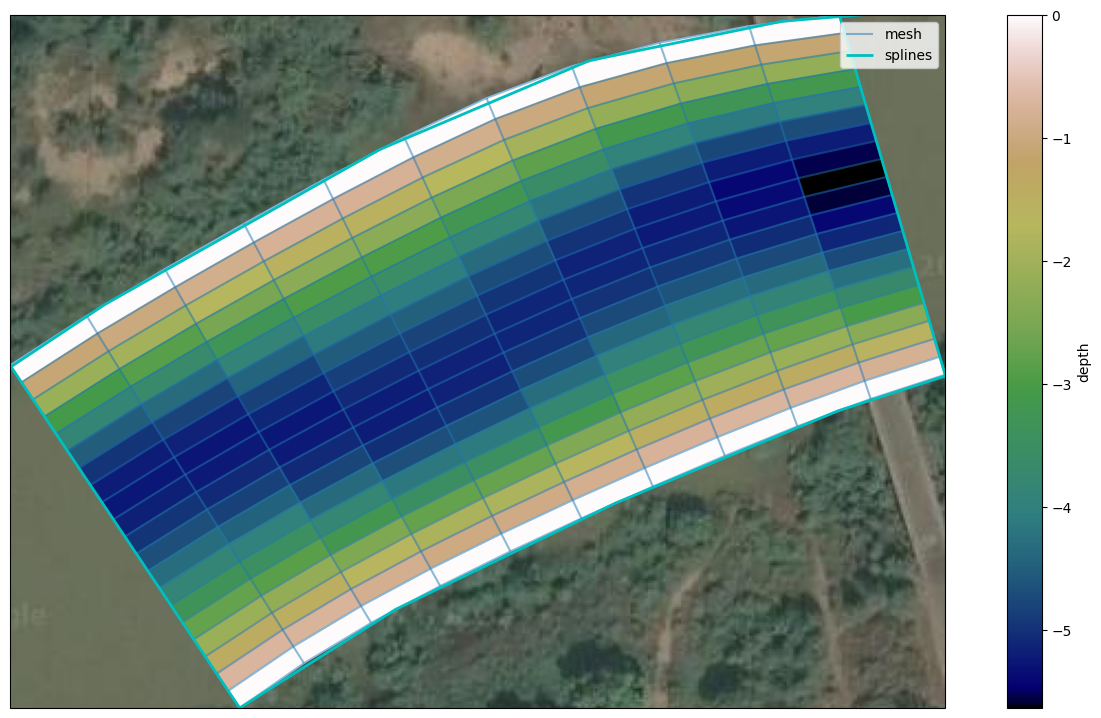

In [27]:
import matplotlib.pyplot as plt

alpha = 10  # amplitude of meander around centerline [m]
L = 200  # wave length m
A = 350  # conveyance surface m2
c = 1.0  # width to grid width ratio [-]
kappa = -.25*np.pi  # phase [rad]

# optimized parameters are below
# alpha, L, kappa, c, A = [10, 39.4624431, 0.204105903, 1.188, 429.690415]


# optimized large-scale parameters, smaller scale defined by user??
# L = 200
# kappa = -.25*np.pi  # phase [rad]
# alpha = 30

# we use the depth_2d function of orprofile to make a depth estimate using the 5 parameters. Input is the mesh, and the 5 parameters.
ds_depth = api.depth_2d(mesh, alpha, L, kappa, c, A)

# mesh.points["depth"] = mesh.points["Depth"] - 116.1

f = plt.figure(figsize=(16, 9))
ax = mesh.plot(points_kw={"cmap": "gist_earth", "vmin": ds_depth["depth"].min(), "vmax": ds_depth["depth"].max()})
ds_depth = ds_depth.ugrid.to_crs(ax.projection)
ds_depth["depth"].ugrid.plot(ax=ax, cmap="gist_earth")

This can be totally wrong of course, and also the resolution is really poor. Let's first improve the resolution, by making a new mesh with more detail and rerun everything. 

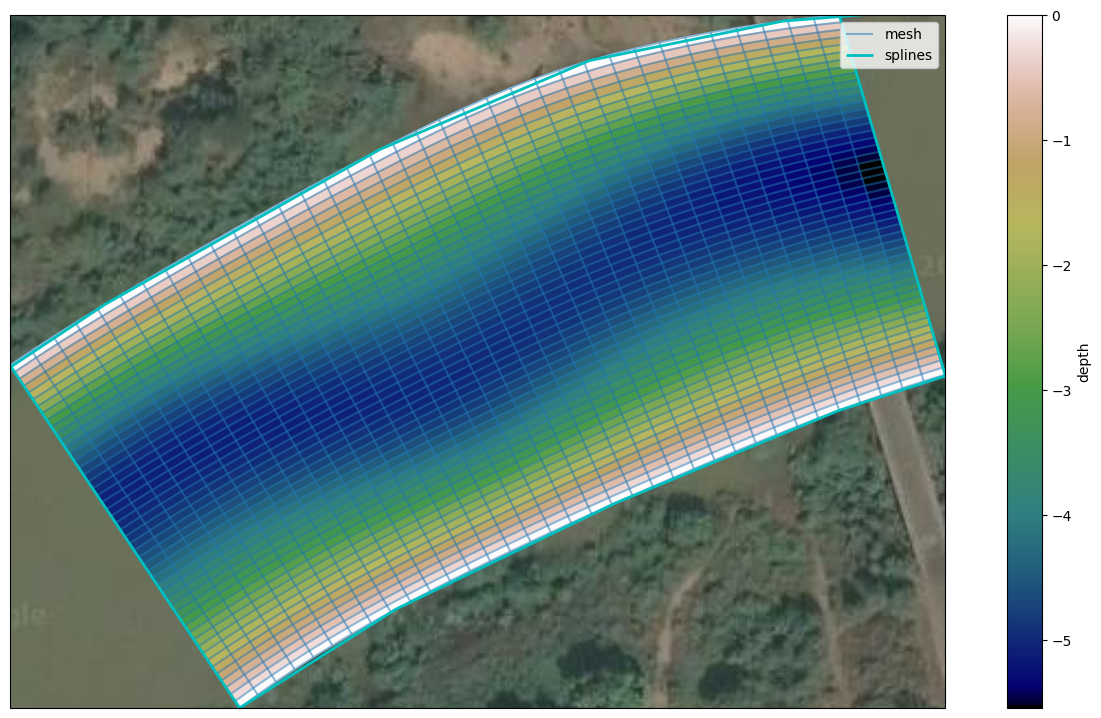

In [31]:
mesh_high_res = api.mesh.Mesh(splines, n=50, m=35)

ds_depth_high_res = api.depth_2d(mesh_high_res, alpha, L, kappa, c, A)

f = plt.figure(figsize=(16, 9))
ax = mesh_high_res.plot()
# change the projection to match the projection of the axes
ds_depth_high_res = ds_depth_high_res.ugrid.to_crs(ax.projection)
ds_depth_high_res["depth"].ugrid.plot(ax=ax, cmap="gist_earth")


You can see here that the mesh is slightly narrower on the upstream (right) side. This means that the 5-parameter model, in order to ensure that the conveyance surface remains the same, also requires more depth in the middel than on the downstream side. Let's now confront this with some observations. You can do this by adding observations to the mesh a plot it again.